# Assignment 7: Exploring 3D Sinusoidal Data using Artificial Neural Networks
## DTSC 680: Applied Machine Learning

## Name: Tyrone Amos Myers

## Directions and Overview

The main purpose of this assignment is for you to gain experience using artificial neural networks to solve simple regression problems.  In this assignment, you will fit a neural network to a noisy 3D sinusoidal data set.  You will use a `Sequential` model that can be trained very quickly on the supplied data, so I want you to manually adjust hyperparameter values and observe their influence on the model's predictions.  That is, you should manually sweep the hyperparameter space and try to hone in on the reasonable hyperparameter values, again, _manually_.  (Yep, that means guess-and-check: pick some values, train the model, observe the prediction curve, repeat.)

So, play around and build some models.  When you are done playing with hyperparameter values, you should finish by building an ANN that models the data reasonably well! You should be able to train a model and use it to predict a curve at least as good as mine, but your goal should be to obtain a smoother and less erratic curve.

(Side Note: Achieving a less erratic prediction curve could be done either by building a better model, ___OR___ by sorting the data more intelligently thereby plotting a prediction curve that looks better.  I propose the ideal line is created by sorting the data in such a way that the resulting line minimizes the arc length of the curve. You don't need to worry about any of this, however you do need to generate a figure with a descent-looking prediction curve superimposed on the data.)

Here just just a few of the hyperparameters you can play around with:

- number of nodes per layer
- number of layers
- activation functions
- normalization method (should be negligible)
- number of epochs
- learning rate
- loss function

You will know that you have obtained a reasonable model when the model's prediction curve looks reasonable.  ___Below you will be asked to plot the model's prediction curve along with the training data.  Even if you correctly train the model, you may find that your trendline looks totally crazy and out-of-this-world when you first plot it.  If this happens to you, try plotting the model's predictions using a scatter plot rather than a connected line plot.  You should be able to infer the problem and solution with plotting the trendline from examining this new scatter plot of the model's predictions.  Your final submission, however, should contain a connected line plot.___  

Lastly in this assignment, you will compute the generalization error on the test set.

## Preliminaries

Let's import some common packages:

In [1]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd
%matplotlib inline
# %matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot3Ddata(data_df):
    # Extract x, y, z coordinates from data_df
    x = data_df['x']
    y = data_df['y']
    z = data_df['z']

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})

    for ax in axs.flat:
        ax.scatter(x, y, z, c='blue')  

        ax.set_xlabel('x', color='red')
        ax.set_ylabel('y', color='red')
        ax.set_zlabel('z', color='red')

    # Set views
    axs[0,0].view_init(2, 88)
    axs[0,1].view_init(25, 0)
    axs[1,0].view_init(24, 89)
    axs[1,1].view_init(90, 90)

    plt.tight_layout()
    plt.show()
    
    
def plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})
    
    for ax in axs.flat:
        # Plot model prediction 
        ax.scatter(fit_x, fit_y, fit_z, c='r')
        
        # Plot training data
        ax.scatter(scat_x, scat_y, scat_z, c='b')
    
    # Labels and limits
    ax.set_xlabel('x', color='red')
    ax.set_ylabel('y', color='red')
    ax.set_zlabel('z', color='red')
    
    ax.set_xlim(min(scat_x), max(scat_x))
    ax.set_ylim(min(scat_y), max(scat_y))
    ax.set_zlim(min(scat_z), max(scat_z))

    # Set views
    axs[0,0].view_init(2, 88)
    axs[0,1].view_init(25, 0)
    axs[1,0].view_init(24, 89)
    axs[1,1].view_init(90, 90)
    
    plt.tight_layout()
    plt.show()

# Import, Split and Standardize Data

Complete the following:



1. Begin by importing the data from the file called `3DSinusoidalANN.csv`.  Name the returned DataFrame `data`.

2. Call [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with a `test_size` of 20%.  Save the output into `X_train`, `X_test`, `y_train`, and `y_test`, respectively. Looking at the below graph, it makes sense for `x` and `z` to be your training data and `y` to be your response data.  Specify the `random_state` parameter to be `42` (do this throughout the entire note book).

3. Next, use the `StandardScaler()` to scale your data.

In [2]:
# Import and explore data
data = pd.read_csv("3DSinusoidalANN.csv")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    # print(data)
    
data

,x,y,z
0,5.003425,-0.097041,0.136004
1,4.914072,-0.049873,-1.726903
2,5.236610,0.257471,-1.838183
3,5.217523,0.212911,-0.669068
4,5.114359,0.808719,0.302012
...,...,...,...
555,-4.948576,0.612473,157.926856
556,-4.980705,0.645476,154.257156
557,-5.021362,0.272735,156.571613
558,-4.953544,0.257083,157.720199


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data 
train_df_unscaled, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Scale the FULL training data
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df_unscaled)

# Extract X and y from SCALED train_df
X_train_scaled = train_df_scaled[:,[0,2]] 
y_train = train_df_scaled[:,1]

# Convert X back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['x','z'])

# Convert y_train to a DataFrame
y_train_df = pd.DataFrame(y_train, columns=['y'])

# Reconstruct final DataFrame
train_df = pd.concat([X_train_scaled_df, y_train_df], axis=1)

# Plot Data

Simply plot your training data here, so that you know what you are working with.  You must define a function called `plot3Ddata`, which accepts a Pandas DataFrame (composed of 3 spatial coordinates) and uses `scatter3D()` to plot the data.  Use this function to plot only the training data (recall that you don't even want to look at the test set, until you are ready to calculate the generalization error).  You must place the definition of this function in the existing code cell of the above __Preliminaries__ section, and have nothing other than the function invocation in the below cell. 

You must emulate the graphs shown in the respective sections below. Each of the graphs will have four subplots. Note the various viewing angles that each subplot presents - you can achieve this with the view_init() method. Be sure to label your axes as shown.

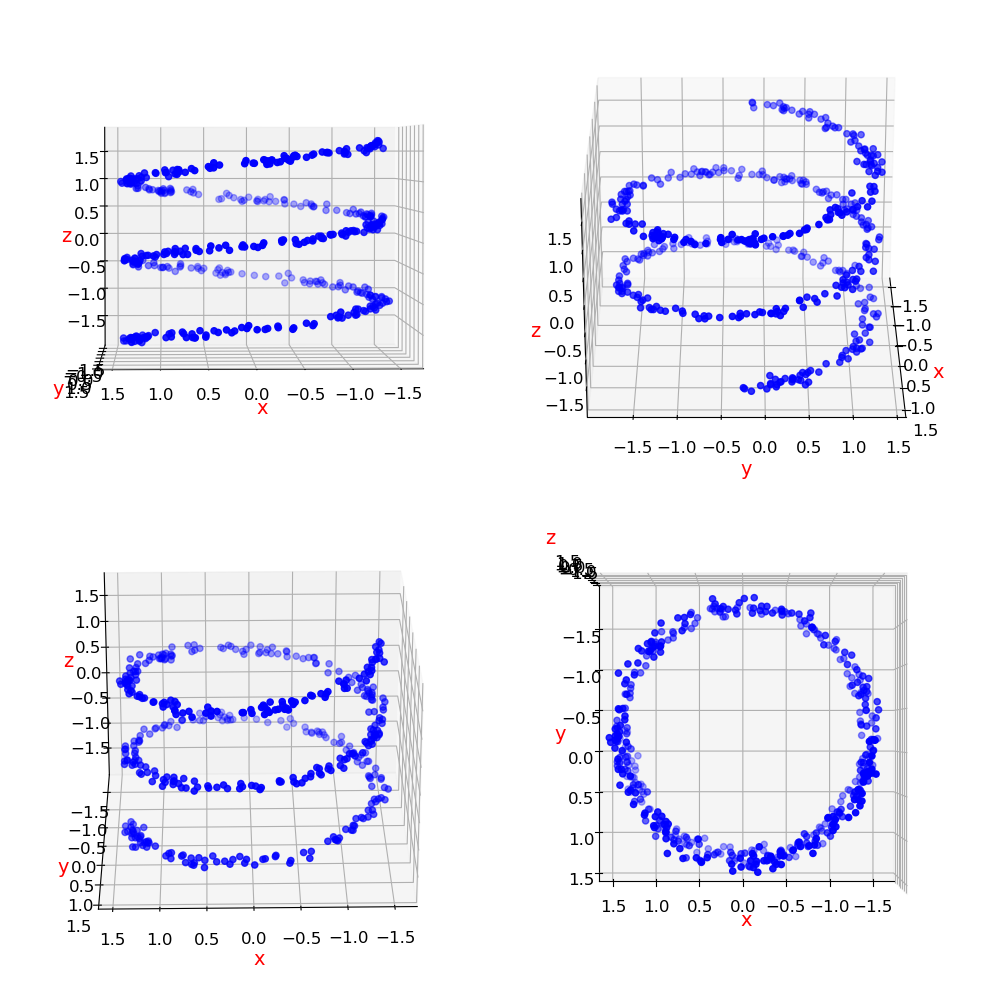

In [4]:
# Plot SCALED training data
plot3Ddata(train_df)

## A Quick Note

In the following sections you will be asked to plot the training data along with the model's predictions for that data superimposed on it.  You must write a function called `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` that will plot this figure.  The function accepts six parameters as input, shown in the function signature.  All six input parameters must be NumPy arrays.  The three Numpy arrays called `fit_x, fit_y,` and  `fit_z` represent the x, y, and z coordinates of the model predictions (i.e. the prediction curve).  The three Numpy arrays called `scat_x, scat_y,` and  `scat_z` represent the x, y, and z coordinates of the training data.   

You must place the definition of the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function in the existing code cell of the above __Preliminaries__ section. (The function header is already there - you must complete the function definition.)  You will use the `plotscatter3Ddata()` function in the following section.

# Explore 3D Sinusoidal Data with Artifical Neural Networks

Fit a `Sequential` model to this data.  You must manually assign values to the hyperparameters, including the number of nuerons per layer and the number of layers.  You should "play around" by using different combinations of hyperparameter values.  When you are done playing, you should build an ANN that models the data well.  Then, you will use that model to calculate the generalization error in the subsequent section.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# I basically copied and adapted this as muc has I could. I have, unfortunately, run out of time. I have about ten minutes
# to take my quiz. I have no idea how far I would have gotten or if I would have done a good job. Hopefully this doesn't cost me
# my grade.
def build_model(n_hidden=2, n_neurons=64):
    model = keras.Sequential()
    model.add(layers.Dense(n_neurons, activation='relu', input_shape=[2]))
    
    for _ in range(n_hidden-1):
        model.add(layers.Dense(n_neurons, activation='relu'))
        model.add(layers.Dense(1))
        model.compile(loss='mse', optimizer='adam')
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# Fit model
keras_reg.fit(X_train_scaled_df, y_train_df, epochs=100, validation_split=0.2, 
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


C:\Users\Tyrone\AppData\Local\Temp\ipykernel_49144\3448602666.py:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


12/12 [==============================] - 0s 14ms/step - loss: 1.0318 - val_loss: 0.9150
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9682 - val_loss: 0.8988
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9374 - val_loss: 0.8920
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9168 - val_loss: 0.8906
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8983 - val_loss: 0.8820
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8867 - val_loss: 0.8770
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8685 - val_loss: 0.8553
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8536 - val_loss: 0.8453
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8358 - val_loss: 0.8279
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.8229 - val_loss: 0.8001
Epoch 11/100
12/12 [

12/12 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0573
Epoch 84/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0598
Epoch 85/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0555
Epoch 86/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0567
Epoch 87/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0598
Epoch 88/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.0564
Epoch 89/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0561
Epoch 90/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0561
Epoch 91/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0606
Epoch 92/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0613
Epoch 93/100


### Plot Model Predictions for Training Set

Use the model's `predict()` method to make a prediction for `y` using the `x` and `z` training data.  Use the `plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)` function to plot the data and the prediction curve.

In [6]:
# Predict on training data
y_pred = keras_reg.predict(X_train_scaled_df)

14/14 [==============================] - 0s 844us/step


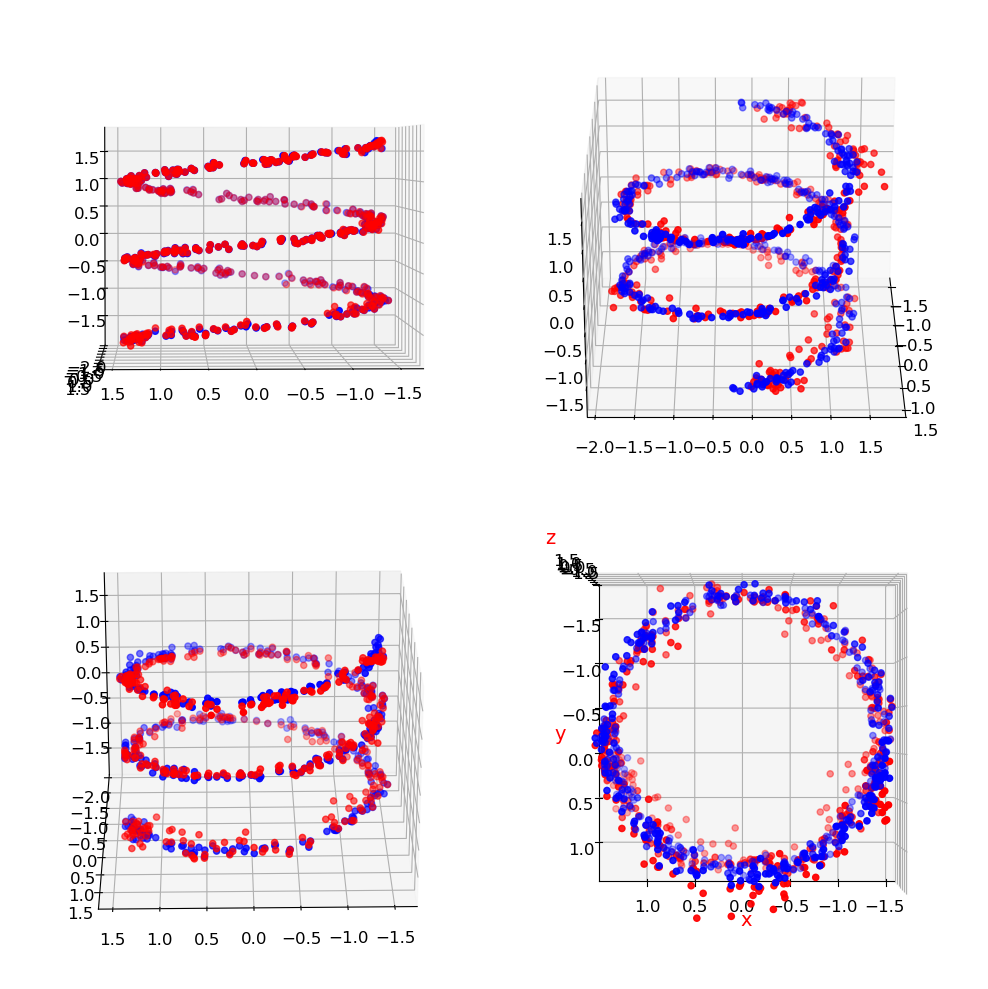

In [7]:
# Extract NumPy arrays from DataFrames 
fit_x = X_train_scaled_df.values[:,0]
fit_y = y_pred
fit_z = X_train_scaled_df.values[:,1]

scat_x = X_train_scaled_df.values[:,0]  
scat_y = y_train_df.values
scat_z = X_train_scaled_df.values[:,1]

plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)

In [8]:
### ENTER CODE HERE ###

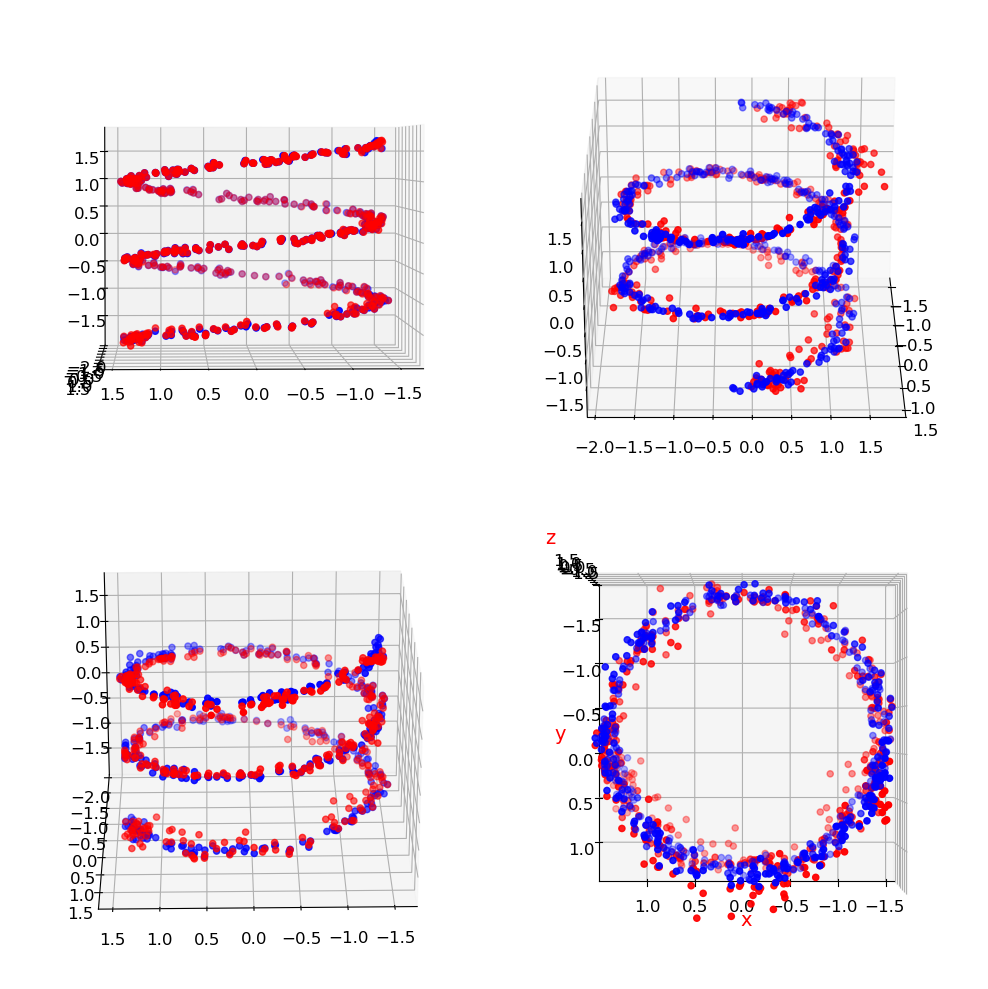

In [9]:
plotscatter3Ddata(fit_x, fit_y, fit_z, scat_x, scat_y, scat_z)

# Compute Generalization Error

Compute the generalization error and use MSE as the generalization error metric.  Round your answers to four decimal places.  Print the generalization error for the model.

In [10]:
### ENTER CODE HERE ###